<a href="https://colab.research.google.com/github/FirasBellakhel/covid-detection-/blob/main/Detection_CNN_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Google Drive to access Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/data'

Mounted at /content/drive
[Errno 2] No such file or directory: '/content/drive/MyDrive/data'
/content


# Import

In [3]:
from __future__ import print_function, division
from builtins import range, input
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 50
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/data/chest/Chest_COVID/'
noncovid_path = '/content/drive/MyDrive/data/chest/Chest_NonCOVID/'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

# Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

# Visualize First 40 Images from Data set

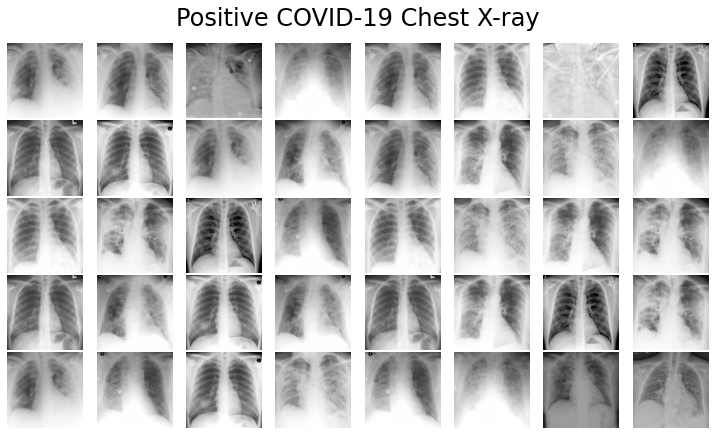

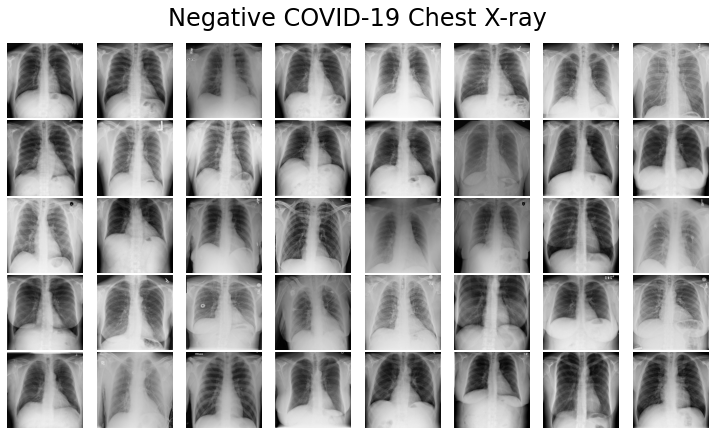

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

# Normalization

In [ ]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# Visualize a few images from Training and Test sets

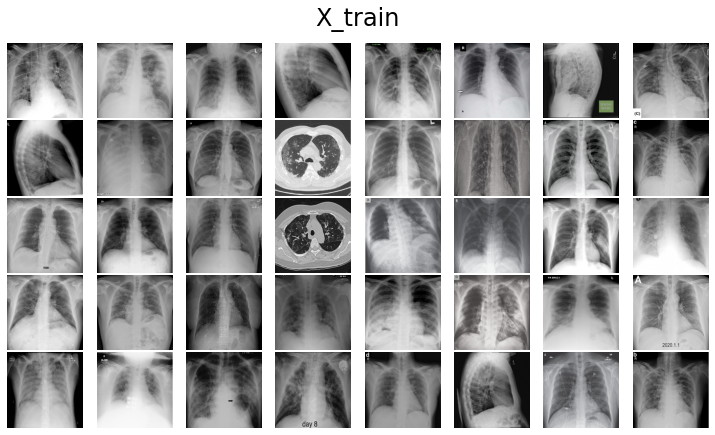

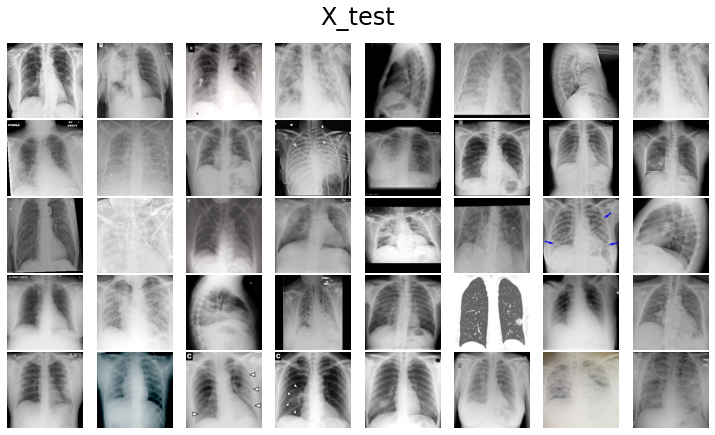

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

# Building and Visualizing model

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='Same', input_shape = (224,224,3), activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size = (2,2)))
    # 25% of the nodes will be dropped out
model.add(Dropout(0.25)) 
model.add(Conv2D(128, kernel_size=(3,3), padding='Same', activation='relu', kernel_initializer = 'glorot_uniform'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
    
    
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='normal'))
model.add(Dense(128, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'softmax'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 128)       0

# Training the model

In [ ]:
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_loss",verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]


In [ ]:
history = model.fit(X_train,y_train, batch_size = 32, 
                    epochs = 50, validation_data = (X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    callbacks=my_callbacks) 

Epoch 1/50
24/24 [==============================] - 17s 293ms/step - loss: 1.0564 - accuracy: 0.5091 - val_loss: 0.6890 - val_accuracy: 0.5619
Epoch 2/50
24/24 [==============================] - 5s 227ms/step - loss: 0.6545 - accuracy: 0.6075 - val_loss: 0.4974 - val_accuracy: 0.7423
Epoch 3/50
24/24 [==============================] - 6s 233ms/step - loss: 0.5300 - accuracy: 0.7150 - val_loss: 0.4722 - val_accuracy: 0.8247
Epoch 4/50
24/24 [==============================] - 6s 257ms/step - loss: 0.4329 - accuracy: 0.8083 - val_loss: 0.3917 - val_accuracy: 0.8196
Epoch 5/50
24/24 [==============================] - 6s 256ms/step - loss: 0.3393 - accuracy: 0.8497 - val_loss: 0.4190 - val_accuracy: 0.8351
Epoch 6/50
24/24 [==============================] - 6s 251ms/step - loss: 0.3466 - accuracy: 0.8601 - val_loss: 0.3644 - val_accuracy: 0.8814
Epoch 7/50
24/24 [==============================] - 6s 235ms/step - loss: 0.2394 - accuracy: 0.8964 - val_loss: 0.3672 - val_accuracy: 0.8660
Epoch

In [ ]:
preds = model.predict(X_test)
prediction = np.argmax(preds[0])
model.evaluate(X_test,y_test)

7/7 [==============================] - 0s 33ms/step - loss: 0.5096 - accuracy: 0.8763


[0.5096176266670227, 0.876288652420044]

# Save Model

In [ ]:
model.save('CNN_Detect_new_es.h5')

# Visulaizing First 10 predictions

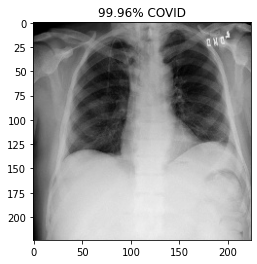

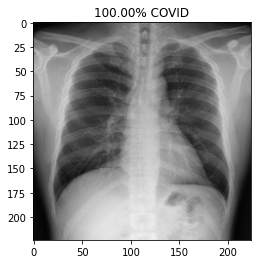

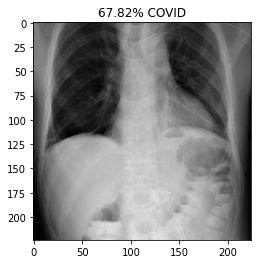

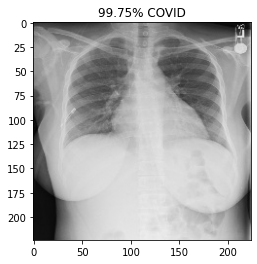

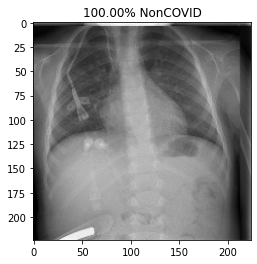

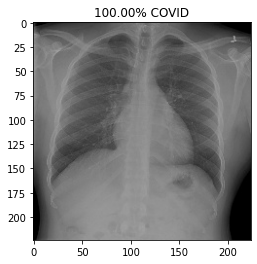

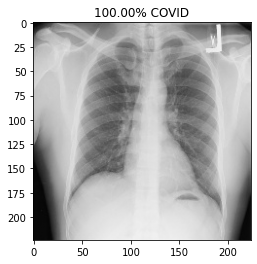

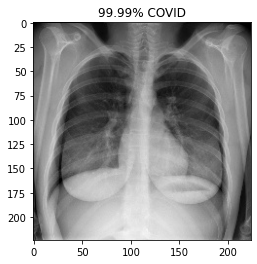

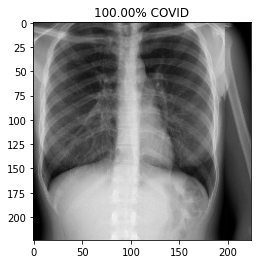

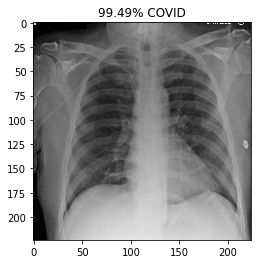

In [ ]:
prediction=preds[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(preds, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

# Confusion Matrix

Confusion Matrix without Normalization


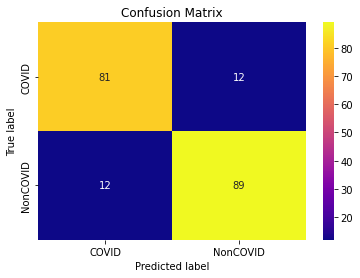

Confusion Matrix with Normalized Values


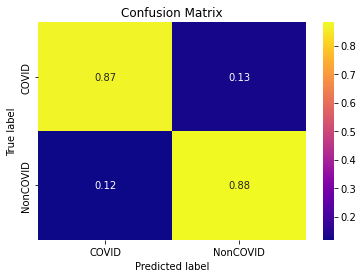

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve

def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

# Curve ROC

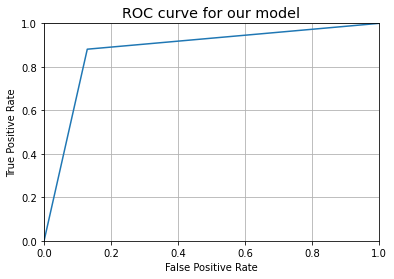

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# Precision

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        93
           1       0.88      0.88      0.88       101

    accuracy                           0.88       194
   macro avg       0.88      0.88      0.88       194
weighted avg       0.88      0.88      0.88       194



# Accuracy

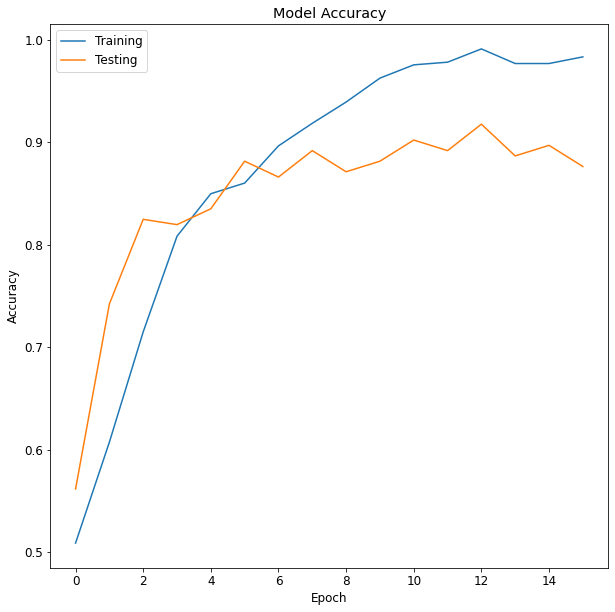

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_accuracy.png')
plt.show()


# Loss

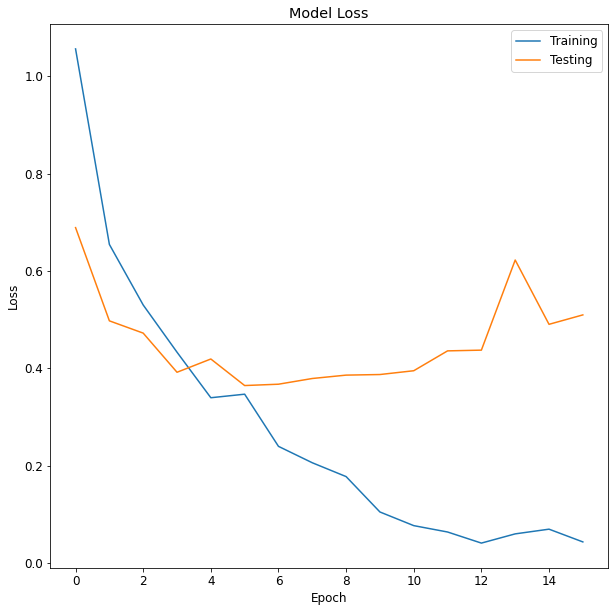

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('xception_chest_loss.png')
plt.show()